In [1]:
import os
import numpy as np
from PIL import Image
from scipy import ndimage, stats
from scipy.fft import fft, fftfreq
import skimage.io
from skimage.measure import regionprops, label, find_contours
from skimage.segmentation import flood
import matplotlib.pyplot as plt
from scipy.ndimage import shift, distance_transform_edt, rotate, map_coordinates, zoom
import tifffile as tiff
import cv2
import glob
from scipy.signal import wiener, find_peaks
from circle_fit import taubinSVD, plot_data_circle, hyperSVD, prattSVD, hyperLSQ, lm, standardLSQ

# Paths

Working directory

In [2]:
# save_dir = "C:/Users/biof/Desktop/chloe/surgele/test_gui/tests_0404"
save_dir = "D:/surgele/juillet/tests_2107"
# save_dir = "C:/Users/chloe/Desktop/juillet/tests_1007"

Files paths

In [3]:
file_path0=os.path.join(save_dir,'ref2.tiff')       
file_path=os.path.join(save_dir,'plain2.tiff')
file_path_patternS = sorted(glob.glob(os.path.join(save_dir,'speckles/*.tiff')))
bg_path=os.path.join(save_dir,'bg2.tiff')

#  Functions LFM

In [4]:
def pre_processing(angle, pitch, file_path, bg_path=None):
   LFM1 = skimage.io.imread(file_path)
   if bg_path != None:
       bg = skimage.io.imread(bg_path)
       LFM1 = (LFM1 - bg)
   img_rotated = ndimage.rotate(LFM1, angle, reshape=False) 
   LFM1 = img_rotated.astype(np.int32)
   h, w = LFM1.shape[:2]
   fraction1 = 15/pitch
   fraction2 = 15/pitch
   img_resized = np.array(Image.fromarray(LFM1, mode='I').resize((int(fraction1 * w), int(fraction2 * h)), Image.Resampling.BILINEAR))
   return img_resized

# Number of microlenses in X and Y on the raw image (140 x 140 for us)
Nx=140
Ny=140

def calibrate_LFM3(img, x, y):
    step = 15  # espacement entre microlentilles

    LFM = np.zeros((Nx, Ny, step, step))
    XX = np.zeros((Nx, Ny))
    YY = np.zeros((Nx, Ny))
    CenterX = np.zeros((Nx, Ny))
    CenterY = np.zeros((Nx, Ny))
    CenterX_ini = np.zeros((Nx, Ny))
    CenterY_ini = np.zeros((Nx, Ny))

    for ii in range(Nx):
        for jj in range(Ny):

            if ii == 0 and jj == 0:
                cx, cy = x, y
            elif ii == 0:
                # première ligne : moyenne impossible, on prend celle de gauche
                cx = CenterX[ii, jj - 1] + step
                cy = CenterY[ii, jj - 1]
            elif jj == 0:
                # premiere colonne : moyenne impossible, se base sur la lentille au-dessus
                cx = CenterX[ii - 1, jj]
                cy = CenterY[ii - 1, jj] + step
            else:
                # moyenne entre la lentille de gauche et celle du dessus
                cx = (CenterX[ii - 1, jj] + CenterX[ii, jj - 1] + step) / 2
                cy = (CenterY[ii - 1, jj] + CenterY[ii, jj - 1] + step) / 2

            # ancienne methode (voir en bas)
            # if ii==0 and jj==0:
            #     CenterX[ii,jj]=x0
            #     CenterY[ii,jj]=y0
            # elif ii==0 and jj!=0:
            #     CenterX[ii,jj]=CenterX[ii,jj-1]+15
            #     CenterY[ii,jj]=CenterY[ii,jj-1]
            # elif ii!=0 and jj==0:
            #     CenterX[ii,jj]=CenterX[ii-1,jj]
            #     CenterY[ii,jj]=CenterY[ii-1,jj]+15
            # else:
            #     CenterX[ii,jj]=CenterX[ii,jj-1]+15
            #     CenterY[ii,jj]=CenterY[ii,jj-1]

            cx = int(cx)
            cy = int(cy)

            # extraction de la microlentille dans l'image
            intermediate = img[cy-(step//2):cy+(step//2 + 1), cx-(step//2):cx+(step//2 + 1)]
            intermediate = intermediate.astype(float)
            
            max_pos = np.unravel_index(np.argmax(intermediate), intermediate.shape)
            thresh = np.percentile(intermediate, 30)
            flooded = flood(intermediate, seed_point=max_pos, tolerance=intermediate[max_pos]-thresh)

            ##### Méthode centre de masse #####
            # a = ndimage.center_of_mass(flooded)
            # ymax = round(a[0])
            # xmax = round(a[1])

            # a = ndimage.center_of_mass(flooded)
            # ymax = round(a[0])
            # xmax = round(a[1])

            ##### Autre méthode géométrique #####
            # (center_y,center_x) = get_max_distance_center2(flooded)
            # ymax = round(center_y)
            # xmax = round(center_x)

            ##### Contours + Circle-fit #####
            flooded = flooded.astype(np.uint8)
            contours, _ = cv2.findContours(flooded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            main_contour = min(contours, key=len)
            points = main_contour[:, 0, :]  # de (n,1,2) vers (n,2)
            fit = taubinSVD(points)
            ymax = round(fit[1])
            xmax = round(fit[0])
            y = fit[1] 
            if ii==0 and jj==0:
                plot_data_circle(points, fit[0], fit[1], fit[2])
                plt.imshow(intermediate)
                plt.contour(flooded, colors='r')
                plt.plot(xmax, ymax, 'bo')  # Nouveau centre géométrique
                plt.gca().invert_yaxis()
                plt.title("Contours et centre (0,0)")
                plt.show()
            if ii==70 and jj==70:
                plot_data_circle(points, fit[0], fit[1], fit[2])
                plt.imshow(intermediate)
                plt.contour(flooded, colors='r')
                plt.plot(xmax, ymax, 'bo')  # Nouveau centre géométrique
                plt.gca().invert_yaxis()
                plt.title("Contours et centre (70,70)")
                plt.show()
            if ii==139 and jj==139:
                plot_data_circle(points, fit[0], fit[1], fit[2])
                plt.imshow(intermediate)
                plt.contour(flooded, colors='r')
                plt.plot(xmax, ymax, 'bo')  # Nouveau centre géométrique
                plt.gca().invert_yaxis()
                plt.title("Contours et centre (139,139)")
                plt.show()
            
            dx = xmax - (step // 2)
            dy = ymax - (step // 2)

            XX[ii, jj] = dx
            YY[ii, jj] = dy

            # ajustement du centre
            cx_adj = cx + dx
            cy_adj = cy + dy
            CenterX_ini[ii, jj] = cx
            CenterY_ini[ii, jj] = cy
            CenterX[ii, jj] = cx_adj
            CenterY[ii, jj] = cy_adj

            # Ré-extraction de la micro-image ajustée
            LFM[ii, jj] = img[cy_adj-(step//2):cy_adj+(step//2 + 1), cx_adj-(step//2):cx_adj+(step//2 + 1)]

    return LFM, CenterX, CenterY, XX, YY, CenterX_ini, CenterY_ini

def get_max_distance_center2(flooded):
    labeled = label(flooded)
    props = regionprops(labeled)
    best_center = None
    best_score = -1
    for region in props:
        minr, minc, maxr, maxc = region.bbox
        if minr == 0 or minc == 0 or maxr == flooded.shape[0] or maxc == flooded.shape[1]:
            continue  # ignore si ca touche le bord de la sous image
        mask = (labeled == region.label)
        dist = distance_transform_edt(mask)
        max_idx = np.unravel_index(np.argmax(dist), dist.shape)
        score = dist[max_idx]
        if score > best_score:
            best_score = score
            best_center = max_idx
    return best_center if best_center is not None else (ndimage.center_of_mass(flooded))

def compute_LFM(img, CenterX, CenterY, XX, YY):
    step = 15
    LFM = np.zeros([Nx, Ny, 15, 15])
    for ii in range(0, Nx):
        for jj in range(0, Ny):    
            LFM[ii, jj, :, :] = img[int(CenterY[ii, jj])-(step//2):int(CenterY[ii, jj])+(step//2 + 1), 
                                     int(CenterX[ii, jj])-(step//2):int(CenterX[ii, jj])+(step//2 + 1)]   
    return LFM

def rendered_focus(C,rendered_height, rendered_width, side, radiance, returnVal=False):
    rendered = np.zeros((rendered_height, rendered_width))
    center_uv = int(side/2)
    for u in range(0, side):
        for v in range(0, side):
            shift_x, shift_y = C*(center_uv-u), C*(center_uv-v)
            rendered[:, :] += shift(radiance[:, :, u, v], (shift_x, shift_y))
    final = rendered / (side*side)
    if returnVal:
        return final

# Basic LFM

Find Angle then Pitch (according to best angle)

In [27]:
def estimate_pitch_and_angle(image, angle_range=(-0.1, 0), angle_step=0.001, axis='horizontal'):
    best_score = -np.inf
    best_angle = 0
    best_projection = None
    
    # Étape 1 : recherche de l'angle optimal
    angles = np.arange(angle_range[0], angle_range[1], angle_step)
    for angle in angles:
        rotated = rotate(image, angle, reshape=False, order=1)
        if axis == 'horizontal':
            projection = np.mean(rotated, axis=0)
        else:
            projection = np.mean(rotated, axis=1)
        score = np.max(projection)  # peut être remplacé par np.max(fft_magnitude), etc.
        if score > best_score:
            best_score = score
            best_angle = angle
            best_projection = projection
    
    # Étape 2 : calcul du pitch à partir de la FFT de la meilleure projection
    projection = best_projection - np.mean(best_projection)  # centrer pour enlever le DC
    fft_mag = np.abs(fft(projection))
    freqs = fftfreq(len(projection))
    
    # Garder uniquement les fréquences positives
    pos_mask = freqs > 0
    fft_mag = fft_mag[pos_mask]
    freqs = freqs[pos_mask]
    
    # Trouver le pic dominant (sauf DC)
    peak_idx = np.argmax(fft_mag)
    peak_freq = freqs[peak_idx]
    pitch = 1 / peak_freq  # conversion fréquence → pitch en pixels
    
    return pitch, best_angle

ref = skimage.io.imread(file_path0)
bg = skimage.io.imread(bg_path)
lfm = ref - bg
pitch, angle = estimate_pitch_and_angle(lfm, angle_range=(-0.5, 0), angle_step=0.01, axis='horizontal')
print(pitch, angle)

14.027397260273972 -0.08999999999999964


Pre-processing

In [5]:
angle = -0.089 # -0.057 pour les tests de mai
pitch = 14.02 

calibration_image=pre_processing(angle, pitch, file_path0, bg_path=None)
bright=pre_processing(angle,pitch, file_path, bg_path=None)

# tiff.imwrite(os.path.join(save_dir, 'calibration_image.tiff'), calibration_image)

Calibration

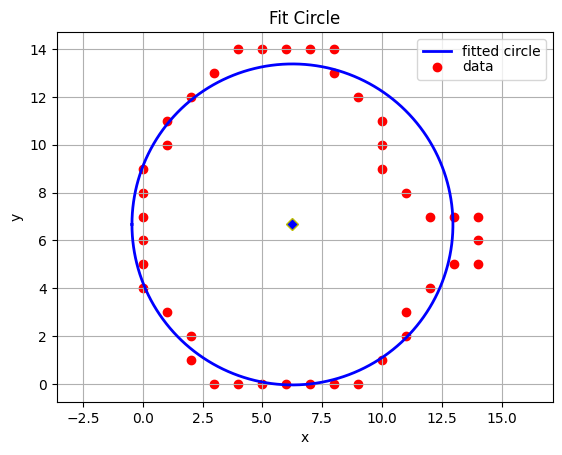

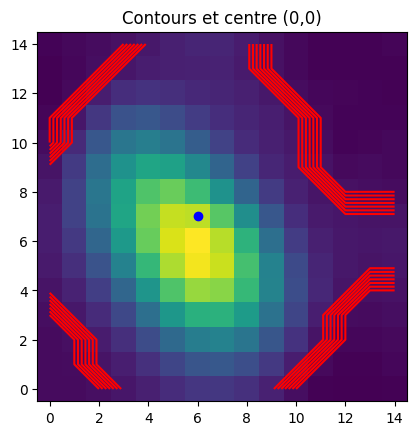

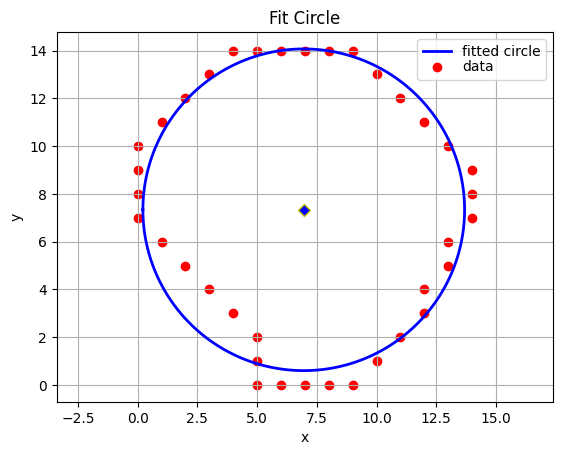

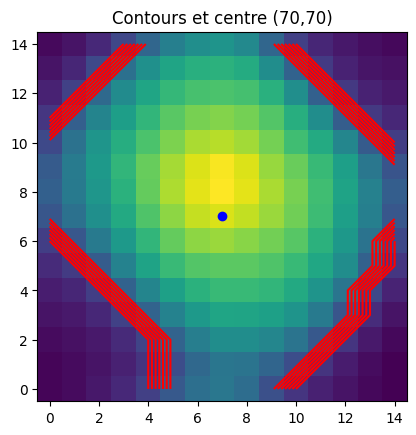

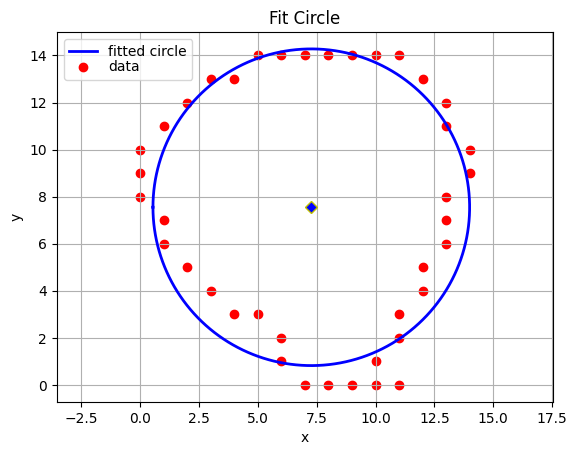

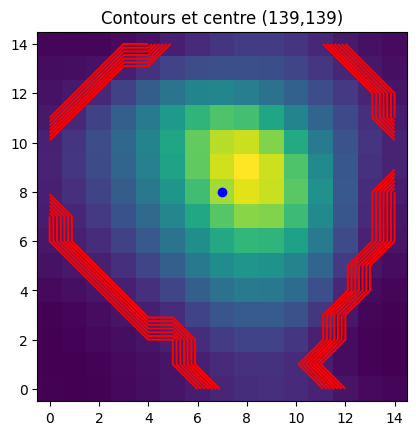

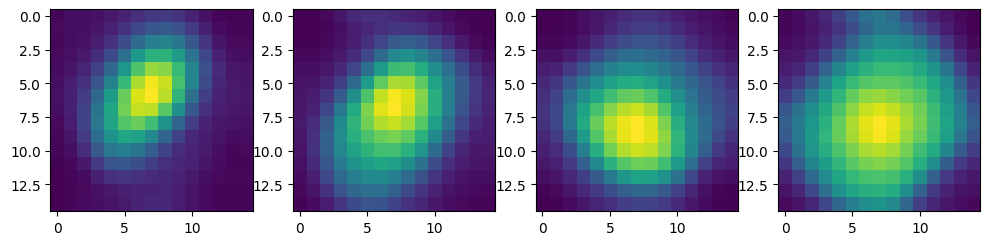

In [6]:
x0 = 10 # 1er centre à choisir en fonction de calibration_image
y0 = 14

LFM,centerX,centerY,CX,CY, centerX_ini, centerY_ini=calibrate_LFM3(calibration_image, x0, y0)
REF = compute_LFM(calibration_image, centerX,centerY,CX,CY)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(REF[0,0,:,:])
plt.subplot(1, 4, 2)
plt.imshow(REF[10,10,:,:])
plt.subplot(1, 4, 3)
plt.imshow(REF[130,30,:,:])
plt.subplot(1, 4, 4)
plt.imshow(REF[70,70,:,:])
plt.show()


CX and CY Plots

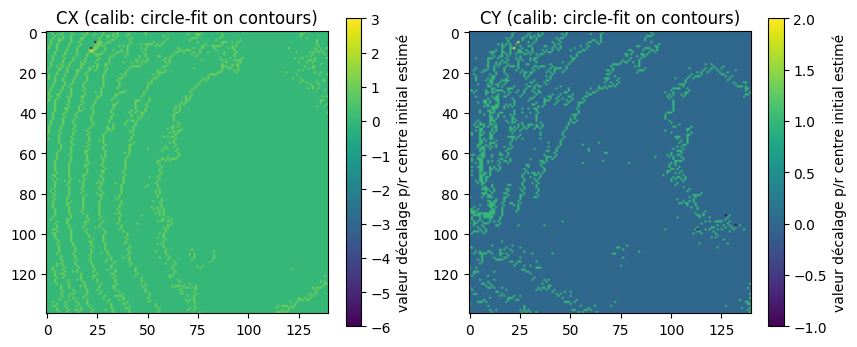

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(CX)
plt.colorbar(label='valeur décalage p/r centre initial estimé')
plt.title("CX (calib: circle-fit on contours)")
plt.subplot(1, 2, 2)
plt.imshow(CY)
plt.colorbar(label='valeur décalage p/r centre initial estimé')
plt.title("CY (calib: circle-fit on contours)")
plt.show()

LFM Computation

In [8]:
                              
LFM01=compute_LFM((bright/(calibration_image+1))*np.mean(calibration_image),centerX,centerY, CX, CY)
# LFM01=compute_LFM(cv2.normalize(bright, None, 0, 65536, cv2.NORM_MINMAX),centerX,centerY, CX, CY)

rendered_height,rendered_width=LFM01.shape[0],LFM01.shape[1]
side=LFM01.shape[2]                                          
radiance=LFM01    

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 4, 1)
# plt.imshow(LFM01[0,0,:,:])
# plt.subplot(1, 4, 2)
# plt.imshow(LFM01[10,9,:,:])
# plt.subplot(1, 4, 3)
# plt.imshow(LFM01[10,10,:,:])
# plt.subplot(1, 4, 4)
# plt.imshow(LFM01[70,70,:,:])
# plt.show()

# LFM Results

LFM Perspectives

In [32]:
stacked_perspectives = np.stack([radiance[:, :, i, j] for i in range(radiance.shape[3]) for j in range(radiance.shape[3])])
tiff.imwrite(os.path.join(save_dir, 'perspectives2.tif'), stacked_perspectives)

In [29]:
persp_1 = radiance[:, :, 7, 1]
persp_2 = radiance[:, :, 7, 13]
# tiff.imwrite(os.path.join(save_dir, 'perspective_centrale.tif'), persp_centrale)

In [14]:
import os
import scipy as sp
import scipy.misc
import imreg_dft as ird

result = ird.similarity(persp_1, persp_2, numiter=3)
result2 = ird.translation(persp_1, persp_2)
tvec = result["tvec"].round(4)
# timg = ird.transform_img(persp_2, tvec=tvec)

# Maybe we don't want to show plots all the time
if os.environ.get("IMSHOW", "yes") == "yes":
    import matplotlib.pyplot as plt
    ird.imshow(persp_1, persp_2, result['timg'])
    # ird.imshow(persp_1, persp_2, timg)
    plt.show()

print("Translation is {}, success rate {:.4g}"
      .format(tuple(tvec), result["success"]))

C:\Users\biof\AppData\Local\Temp\ipykernel_6592\708429876.py:3: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


ModuleNotFoundError: No module named 'imreg_dft'

Epipolar Image Planes (EPI)

In [15]:
stacked_perspectives.shape

(225, 140, 140)

In [ ]:
grid = stacked_perspectives.reshape(15, 15, 140, 140) # (v, u, y, x)

def row_strips(grid, v, y0):
    
    # pick the 15 perspectives along row v
    row_pers = grid[v, :, :, :]        # shape (15, y, x)
    
    # for each, extract the vertical line (column) at y0
    strips = [pers[y0, :] for pers in row_pers]
    
    # stack into (H, 15)
    new_img = np.stack(strips, axis=0)

    return new_img

def col_strips(grid, u, x0):
    
    # pick the 15 perspectives along column c
    col_pers = grid[:, u, :, :]        # shape (15, 140, 140)
    
    # for each, extract the vertical line (column) at x0 
    strips = [pers[:, x0] for pers in col_pers]
    
    # stack into (15, W)
    new_img = np.stack(strips, axis=1)
    return new_img


epi = row_strips(grid, v=7, y0=81)
plt.figure(figsize=(6,6))
plt.imshow(epi, cmap='gray')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Row {7} → horizontal strip at v={81}')
plt.show()

epi2 = col_strips(grid, u=7, x0=33)
plt.figure(figsize=(6,6))
plt.imshow(epi2, cmap='gray')
plt.xlabel('v')
plt.ylabel('y')
plt.title(f'Column {7} → vertical strip at u={33}')
plt.show()

# theorique en shift and sum: slope = 0.033

In [ ]:
from skimage.registration import phase_cross_correlation

def estimate_slope(epi):
    shifts = []
    for i in range(len(epi) - 1):
        a = epi[i][None, :]    # shape (1, x)
        b = epi[i+1][None, :]  # shape (1, x)
        shift, _, _ = phase_cross_correlation(a, b, upsample_factor=10) # shift between one line and another
        shifts.append(shift[1])  # shift along x
    avg_disp = np.mean(shifts) # average on all shifts -> not the best method...
    return avg_disp  # Δx / Δu

def prepare_epi(epi):
    if epi.shape[0] < epi.shape[1]:
        return epi  # already [views, pixels]
    else:
        return epi.T  # flip [pixels, views] → [views, pixels]

epi, epi2 = prepare_epi(epi), prepare_epi(epi2)
slope = estimate_slope(epi)
slope2 = estimate_slope(epi2)
print("Estimated slope:", slope)
print("Estimated slope 2:", slope2)

Estimated slope: -0.08571428571428573
Estimated slope 2: -0.014285714285714287


Shift and Sum zStack

In [10]:
rendered_images=[]  # Array to store the volumetric image 
C_values=np.linspace(-1.5,1.5,80)   # Coefficient C that depends on the depth

for C in (C_values):    # Apply Shift and Sum algorithm: set the depth limits and the number of slices (sampling)
    rendered_image=rendered_focus(C, rendered_height, rendered_width, side, radiance, returnVal=True)
    rendered_image = 65500 * (rendered_image - np.min(rendered_image)) / (np.max(rendered_image) - np.min(rendered_image))
    rendered_images.append(rendered_image)
 
rendered_images_stack=np.stack(rendered_images)

# Save z stack
tiff.imwrite(os.path.join(save_dir,'shiftandsum2.tif'), rendered_images_stack)

Fourier Slice Refocusing

In [33]:
import importlib
import fourierslice_refocusing
importlib.reload(fourierslice_refocusing)

refocus_stack, fft_stack, Z = fourierslice_refocusing.refocus_test(radiance, min=-200, max=200, Padding=False)
tiff.imwrite(os.path.join(save_dir, "fourierslice2.tif"), refocus_stack)
# tiff.imwrite(os.path.join(save_dir, "zstack_fourierslice2FFT.tif"), fft_stack)

# HiLo-LFM Results

To run this part of the code, the sections above must also be executed ! They contain uniform illumination computation.

Structured Illumination: Pre-processing and LFM Computation

In [34]:
radiance_patternS = []
side_patternS = []
rendered_height_patternS = []
rendered_width_patternS = []
i = 1

for file_path_pattern in file_path_patternS:
    pattern = pre_processing(angle, pitch, file_path_pattern, bg_path)
    LFM01_pattern=compute_LFM((pattern/(calibration_image+1))*np.mean(calibration_image),centerX,centerY,CX,CY)
    # LFM01_pattern=compute_LFM(cv2.normalize(pattern, None, 0, 65536, cv2.NORM_MINMAX),centerX,centerY,CX,CY)
    rendered_height_pattern,rendered_width_pattern=LFM01_pattern.shape[0],LFM01_pattern.shape[1]
    side_pattern=LFM01_pattern.shape[2]                                          
    radiance_pattern=LFM01_pattern
    persp = radiance_pattern[:, :, 7, 7]
    # tiff.imwrite(os.path.join(save_dir, f'perspective_centrale_speckle{i}.tiff'), persp)
    print("Array shape:", radiance_pattern.shape)
    print("Max value:", np.max(radiance_pattern))
    i += 1

    radiance_patternS.append(radiance_pattern)
    side_patternS.append(side_pattern)
    rendered_height_patternS.append(rendered_height_pattern)
    rendered_width_patternS.append(rendered_width_pattern)

Array shape: (140, 140, 15, 15)
Max value: 32076.303396483727
Array shape: (140, 140, 15, 15)
Max value: 24393.9660839958
Array shape: (140, 140, 15, 15)
Max value: 26646.445548433443


HiLo-LFM Perspectives

In [35]:
import importlib
import new_hilo1
importlib.reload(new_hilo1)

hilo_perspectives = []

for i in range(radiance.shape[3]):
    for j in range(radiance.shape[3]):
        radiance_structured = [r[:, :, i, j] for r in radiance_patternS]
        # radiance_structured = [cv2.normalize(r[:, :, i, j], None, 0, 65536, cv2.NORM_MINMAX) for r in radiance_patternS]
        # hilo_perspective = hilo.hilo_reconstruction_contrasted(radiance[:, :, i, j], radiance_pattern1[:, :, i, j], radiance_pattern2[:, :, i, j], alpha=1.0, sigma=5)
        # hilo_perspective, I_high, I_high_filtered, I_low_filtered = hilo.hilo_reconstruction2(radiance[:, :, i, j], radiance_structured, alpha=2, sigma=7)
        hilo_perspective, _, _, _ = new_hilo1.basic_hilo(radiance[:, :, i, j], radiance_structured)
        hilo_perspectives.append(hilo_perspective)

hilo_perspectives_stack = np.stack(hilo_perspectives)

# Save HiLo perspectives
tiff.imwrite(os.path.join(save_dir, 'hilo_perspectives2_sigma0.7.tif'), hilo_perspectives_stack)

In [22]:
U = V = int(np.sqrt(hilo_perspectives_stack.shape[0]))
X, Y = hilo_perspectives_stack.shape[1], hilo_perspectives_stack.shape[2]

# (U*V, H, W) -> (U, V, H, W) -> (H, W, U, V)
radiance_hilo = hilo_perspectives_stack.reshape(U, V, X, Y).transpose(2, 3, 0, 1)

Fourier Slice Refocusing in HiLo

In [24]:
import importlib
import fourierslice_refocusing
importlib.reload(fourierslice_refocusing)


hilo_refocus_stack, hilo_fft_stack, Z = fourierslice_refocusing.refocus_test(radiance_hilo, min=-200, max=200, Padding=False)
tiff.imwrite(os.path.join(save_dir, "hilo_fourierslice_v1.tif"), hilo_refocus_stack)
# tiff.imwrite(os.path.join(save_dir, "new_hilo_zstack_fourierslice2FFT.tif"), hilo_fft_stack)

In [36]:
import importlib
import fourierslice_refocusing
importlib.reload(fourierslice_refocusing)
import new_hilo1
importlib.reload(new_hilo1)

hilo_refocused_stackS = []
for rad in radiance_patternS:
    hilo_refocused_stack, _, _ = fourierslice_refocusing.refocus_test(rad, min=-200, max=200, Padding=False)
    hilo_refocused_stackS.append(hilo_refocused_stack)

hilos = []
for i in range(len(refocus_stack)):
    uniform = refocus_stack[i]  # image brute à profondeur i
    structured = [stack[i] for stack in hilo_refocused_stackS[1:]]  # toutes les images structurées à la profondeur i
    I_hilo, I_high, I_high_filtered, I_low_filtered = new_hilo1.basic_hilo(uniform, structured)
    hilos.append(I_hilo)

hilo_stack = np.stack(hilos)

# Save HiLo z stack
tiff.imwrite(os.path.join(save_dir,'hilo_fourierslice2_sigma07.tiff'), hilo_stack)

Shift and Sum HiLo zStack

In [23]:
rendered_images_hilo=[]  # Array to store the volumetric image 

C_values=np.linspace(-1.5,1.5,80)   # Coefficient C that depends on the depth

for C in (C_values):    # Apply Shift and Sum algorithm: set the depth limits and the number of slices
    rendered_image_hilo=rendered_focus(C, rendered_height, rendered_width, side, radiance_hilo, returnVal=True)
    rendered_images_hilo.append(rendered_image_hilo)
 
rendered_images_stack_hilo=np.stack(rendered_images_hilo)

# Save z stack
tiff.imwrite(os.path.join(save_dir,'hilo_shiftandsum4.tif'), rendered_images_stack_hilo)

# Old Versions of Functions

In [ ]:
############# FIND PITCH AND PLOT PITCH MAP ################

# def compute_local_pitch_map(image, patch_size=100, axis='horizontal'):
#     h, w = image.shape
#     step_y = h // patch_size
#     step_x = w // patch_size
#     pitch_map = np.full((step_y, step_x), np.nan)
#     for i in range(step_y):
#         for j in range(step_x):
#             y0 = i*patch_size
#             x0 = j*patch_size
#             patch = image[y0:y0+patch_size, x0:x0+patch_size]
#             if axis == 'horizontal':
#                 profile = np.mean(patch, axis=0)  # moyenne sur les lignes (profil horizontal)
#             elif axis == 'vertical':
#                 profile = np.mean(patch, axis=1)  # moyenne sur les colonnes (profil vertical)
#             else:
#                 raise ValueError("set axis")
#             peaks, _ = find_peaks(profile, distance=8, prominence=10)
#             if len(peaks) >= 2:
#                 pitch = np.mean(np.diff(peaks))
#                 pitch_map[i, j] = pitch
#     return pitch_map

# def plot_pitch_map(pitch_map, title='pitch map'):
#     plt.figure(figsize=(8, 6))
#     plt.imshow(pitch_map, cmap='viridis', origin='upper')
#     plt.colorbar(label='pitch local en pixels')
#     plt.title(title)
#     plt.grid(False)
#     plt.tight_layout()
#     plt.show()


# ref = skimage.io.imread(file_path0)
# bg = skimage.io.imread(bg_path)
# lfm = ref - bg

# # Horizontal
# pitch_map_h = compute_local_pitch_map(lfm, patch_size=100, axis='horizontal')
# plot_pitch_map(pitch_map_h, title="pitch map horizontal")
# pitch_h_moyen = np.nanmean(pitch_map_h)
# pitch_h_max = np.max(pitch_map_h)
# pitch_h_min = np.min(pitch_map_h)
# mode_result_h = stats.mode(pitch_map_h, axis=None, keepdims=False)
# mode_val_h = mode_result_h.mode
# mode_count_h = mode_result_h.count
# print(f"Pitch horizontal moyen : {pitch_h_moyen:.2f} pixels")
# print(f"Pitch horizontal max : {pitch_h_max:.2f} pixels")
# print(f"Pitch horizontal min : {pitch_h_min:.2f} pixels")
# print(f"Mode horizontal: {mode_val_h} (appears {mode_count_h} times)")

# # Vertical
# pitch_map_v = compute_local_pitch_map(lfm, patch_size=100, axis='vertical')
# plot_pitch_map(pitch_map_v, title="pitch map vertical")
# pitch_v_moyen = np.nanmean(pitch_map_v)
# pitch_v_max = np.max(pitch_map_v)
# pitch_v_min = np.min(pitch_map_v)
# mode_result_v = stats.mode(pitch_map_h, axis=None, keepdims=False)
# mode_val_v = mode_result_v.mode
# mode_count_v = mode_result_v.count
# print(f"Pitch vertical moyen : {pitch_v_moyen:.2f} pixels")
# print(f"Pitch vertical max : {pitch_v_max:.2f} pixels")
# print(f"Pitch vertical min : {pitch_v_min:.2f} pixels")
# print(f"Mode horizontal: {mode_val_v} (appears {mode_count_v} times)")

In [ ]:
############ FIND ANGLE OF ROTATION AFTER PITCH ################

# pitch = 14.0 #14.05
# angles = np.arange(-0.1, 0, 0.01)
# scores = []
# for angle in angles:
#     calibration_image=pre_processing(angle, pitch, file_path0, bg_path)
#     projection = np.sum(calibration_image, axis=0)  # somme verticale (profil horizontal)
#     score = np.var(projection)  # ou np.std() ou np.max()-np.min()
#     scores.append(score)

# best_angle = angles[np.argmax(scores)]
# print(f"Meilleur angle d’alignement : {best_angle}°")
# plt.figure()
# plt.plot(angles, scores, marker='o')
# plt.title("Score (variance des colonnes) vs angle de rotation")
# plt.xlabel("Angle (°)")
# plt.ylabel("Score (variance)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
################### OLD HILO ZSTACK RECONSTRUCTION ##################

# rendered_images_patterns = [[] for _ in range(len(radiance_patternS))]  # liste de listes
# C_values = np.linspace(-2.5, 2.5, 80)   # Coefficient C that depends on the depth

# for C in C_values:
#     rendered_images_at_C = []  # les images de tous les patterns pour ce C

#     for i in range(len(radiance_patternS)):
#         rendered_image = rendered_focus(C, rendered_height_patternS[i], rendered_width_patternS[i], side_patternS[i], radiance_patternS[i], returnVal=True)
#         rendered_images_patterns[i].append(rendered_image)
#         rendered_images_at_C.append(rendered_image)

# # Empilement de toutes les images pour chaque pattern
# rendered_images_stackS = [np.stack(rendered_images) for rendered_images in rendered_images_patterns]


# hilos = []
# for i in range(len(C_values)):
#     uniform = rendered_images_stack[i]  # image brute à profondeur i
#     structured = [stack[i] for stack in rendered_images_stackS[1:]]  # toutes les images structurées à la profondeur i
#     I_hilo, I_high, I_high_filtered, I_low_filtered = hilo.hilo_reconstruction2(uniform, structured, sigma=1)
#     hilos.append(I_hilo)

# hilo_stack = np.stack(hilos)

# # Save HiLo z stack
# tiff.imwrite(os.path.join(save_dir,'hilo_zstack3.tiff'), hilo_stack)